In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point

In [2]:
# parameters
start_year = 2009
start_month = 1
start_day = 1

In [3]:
INALT_mask=xr.open_dataset('/gxfs_work/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS104/1_mesh_mask_iMirabilis.nc')
particle_ds = xr.open_dataset(f'/gxfs_work/geomar/smomw523/master-thesis/output_data/INALT20.L46-KFS104/Tides10-Column_test_1500_{start_year:04d}{start_month:02d}{start_day:02d}_RT-42_N-100000_seed-12345.nc')
#SIGMA=xr.open_dataset('/gxfs_work1/geomar/smomw523/master-thesis/data/config/ROMS/sigma2depth_parent.nc')
#ROMS_ds = xr.open_dataset(f'/gxfs_work1/geomar/smomw523/master-thesis/output_data/ROMS/Track-Column_test_1500_{start_year:04d}{start_month:02d}{start_day:02d}_RT-42_N-100000_seed-12345.nc')
#SIGMA_child=xr.open_dataset('/gxfs_work1/geomar/smomw523/master-thesis/data/config/ROMS/sigma2depth_child.nc')
#ROMSchild_ds = xr.open_dataset(f'/gxfs_work1/geomar/smomw523/master-thesis/output_data/ROMS_child/Track-Column_test_1500_{start_year:04d}{start_month:02d}{start_day:02d}_RT-42_N-100000_seed-12345.nc')
particle_ds

<xarray.Dataset>
Dimensions:     (traj: 100000, obs: 44)
Dimensions without coordinates: traj, obs
Data variables:
    lon         (traj, obs) float64 ...
    lat         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    trajectory  (traj, obs) float64 ...
    topography  (traj, obs) float32 ...
    depthdiff   (traj, obs) float32 ...
    distance    (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.3.1
    parcels_mesh:           spherical

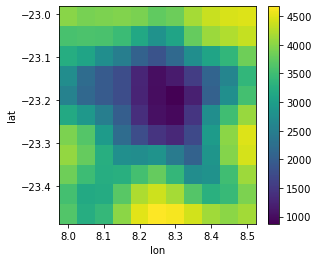

In [4]:
topo_INALT = np.sum((INALT_mask.tmask*INALT_mask.e3t_0).isel(t=0),axis=0)
topo_INALT = topo_INALT.assign_coords({"lon": INALT_mask.glamt.isel(t=0,y=0),
                                       "lat": INALT_mask.gphit.isel(t=0,x=0),
                                      })
topo_INALT = topo_INALT.swap_dims({'x': 'lon', 'y': 'lat'})

plt.figure(figsize=(15,4))
plt.subplot(1, 3,1)
topo_INALT.sel(lon=slice(8,8.5),lat=slice(-23.5,-23)).plot()
#plt.subplot(1, 3,2)
#SIGMA.h.plot()
#plt.subplot(1, 3,3)
#SIGMA_child.h.plot();

In [5]:
MLD = pd.read_csv('/gxfs_work/geomar/smomw523/master-thesis/output_data/retention/MLD2009_s001_EOS80-tides.csv',index_col=0)

In [6]:
# Mixed layer depth at release day
MLD_INALT_1d = MLD.INALT[f'{start_year:04d}-{start_month:02d}-{start_day:02d}']
#MLD_ROMS_1d = MLD.ROMS[f'{start_year:04d}-{start_month:02d}-{start_day:02d}']
#MLD_ROMSchild_1d = MLD.ROMSchild[f'{start_year:04d}-{start_month:02d}-{start_day:02d}']

In [7]:
#Mixed layer depth first 5 days
MLD_INALT_5d = np.mean(MLD.INALT[MLD.INALT.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}'):(
    MLD.INALT.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}')+5)])
#MLD_ROMS_5d = np.mean(MLD.ROMS[MLD.ROMS.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}'):(
#    MLD.ROMS.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}')+5)])
#MLD_ROMSchild_5d = np.mean(MLD.ROMSchild[MLD.ROMSchild.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}'):(
#    MLD.ROMSchild.index.get_loc(f'{start_year:04d}-{start_month:02d}-{start_day:02d}')+5)])

In [8]:
print(MLD_INALT_1d,MLD_INALT_5d)
#print(MLD_ROMS_5d,MLD_ROMS_1d)
#print(MLD_ROMSchild_5d,MLD_ROMSchild_1d)

16.363964 16.363964


In [9]:
releasepoints_INALT = pd.read_csv('/gxfs_work/geomar/smomw523/master-thesis/data/config/releasepoints_INALT.csv',usecols=[2,1]).reindex(columns=['lon','lat'])
#releasepoints_ROMS = pd.read_csv('/gxfs_work1/geomar/smomw523/master-thesis/data/config/releasepoints_ROMS.csv',usecols=[2,1]).reindex(columns=['lon','lat'])
#releasepoints_ROMSchild = pd.read_csv('/gxfs_work1/geomar/smomw523/master-thesis/data/config/releasepoints_ROMSchild.csv',usecols=[2,1]).reindex(columns=['lon','lat'])

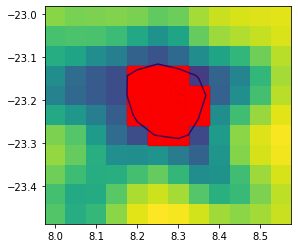

In [10]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3,1)
plt.pcolormesh(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)))#,levels=20)
cl_INALT=plt.contour(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)),levels=[1500])
plt.scatter(releasepoints_INALT['lon'],releasepoints_INALT['lat'],s=0.01,color='red')

# plt.subplot(1, 3,2)
# plt.pcolormesh(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
#             SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
#             SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
# cl_ROMS=plt.contour(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
#             SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
#             SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
# plt.scatter(releasepoints_ROMS['lon'],releasepoints_ROMS['lat'],s=0.01,color='red')
# #ROMS_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.01,color='red')

# plt.subplot(1, 3,3)
# plt.pcolormesh(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
#             SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
#             SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
# cl_ROMSchild=plt.contour(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
#             SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
#             SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
# plt.scatter(releasepoints_ROMSchild['lon'],releasepoints_ROMSchild['lat'],s=0.01,color='red')
# #ROMSchild_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.01,color='red');

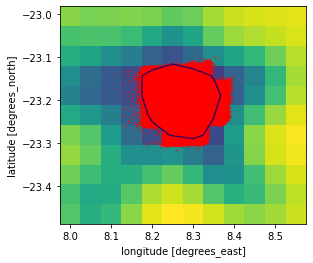

In [11]:
plt.figure(figsize=(15,4))
plt.subplot(1, 3,1)
plt.pcolormesh(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)))#,levels=20)
cl_INALT=plt.contour(topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lon,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)).lat,
            topo_INALT.sel(lon=slice(8,8.6),lat=slice(-23.5,-23)),levels=[1500])
particle_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.1,color='red')

# plt.subplot(1, 3,2)
# plt.pcolormesh(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
#             SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
#             SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
# cl_ROMS=plt.contour(SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
#             SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
#             SIGMA.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
# ROMS_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.1,color='red')

# plt.subplot(1, 3,3)
# plt.pcolormesh(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
#             SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
#             SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)))#,levels=20)
# cl_ROMSchild=plt.contour(SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lon_rho,
#             SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)).lat_rho,
#             SIGMA_child.h.sel(lon_rho=slice(8,8.6),lat_rho=slice(-23.5,-23)),levels=[1500])
# ROMSchild_ds.isel(obs=0).plot.scatter(x='lon',y='lat',s=0.1,color='red');

In [12]:
hull_INALT=ConvexHull(releasepoints_INALT.to_numpy())
# hull_ROMS=ConvexHull(releasepoints_ROMS.to_numpy())
# hull_ROMSchild=ConvexHull(releasepoints_ROMSchild.to_numpy())

#INALT
x = np.array([8.175, 8.325, 8.325, 8.375, 8.375,
              8.325, 8.325, 8.225, 8.225, 8.175])
y = np.array([-23.12069, -23.12069, -23.1666665, -23.1666665, -23.2585715,
              -23.2585715, -23.3045005, -23.3045005, -23.2585715, -23.2585715])
#x = releasepoints_INALT.to_numpy()[hull_INALT.vertices, 0]
#y = releasepoints_INALT.to_numpy()[hull_INALT.vertices, 1]
#z = releasepoints_INALT.to_numpy()[hull_INALT.vertices, 2]
poly_INALT = Polygon([(i[0], i[1]) for i in zip(x,y)])
    
# #ROMS
# x = releasepoints_ROMS.to_numpy()[hull_ROMS.vertices, 0]
# y = releasepoints_ROMS.to_numpy()[hull_ROMS.vertices, 1]
# #z = releasepoints_ROMS.to_numpy()[hull_ROMS.vertices, 2]
# poly_ROMS = Polygon([(i[0], i[1]) for i in zip(x,y)])
    
# #ROMSchild
# x = releasepoints_ROMSchild.to_numpy()[hull_ROMSchild.vertices, 0]
# y = releasepoints_ROMSchild.to_numpy()[hull_ROMSchild.vertices, 1]
# #z = releasepoints_ROMSchild.to_numpy()[hull_ROMSchild.vertices, 2]
# poly_ROMSchild = Polygon([(i[0], i[1]) for i in zip(x,y)])

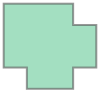

In [13]:
poly_INALT

In [15]:
#particle_ds['depthdiff'] = particle_ds.topography-particle_ds.z
# ROMS_ds['depthdiff'] = ROMS_ds.topography-ROMS_ds.z
# ROMSchild_ds['depthdiff'] = ROMSchild_ds.topography-ROMSchild_ds.z

In [16]:
%%time

df_INALT1 = particle_ds.where(particle_ds.isel(obs=0).z<=MLD_INALT_5d,drop=True).to_dataframe()
df_INALT2 = particle_ds.where((particle_ds.isel(obs=0).z>MLD_INALT_5d) & (particle_ds.isel(obs=0).depthdiff > 100),drop=True).to_dataframe()
df_INALT3 = particle_ds.where((particle_ds.isel(obs=0).depthdiff < 100), drop=True).to_dataframe()

# df_ROMS1 = ROMS_ds.where(ROMS_ds.isel(obs=0).z<=MLD_ROMS_5d,drop=True).to_dataframe()
# df_ROMS2 = ROMS_ds.where((ROMS_ds.isel(obs=0).z>MLD_ROMS_5d) & (ROMS_ds.isel(obs=0).depthdiff > 100),drop=True).to_dataframe()
# df_ROMS3 = ROMS_ds.where((ROMS_ds.isel(obs=0).depthdiff < 100),drop=True).to_dataframe()

# df_ROMSchild1 = ROMSchild_ds.where(ROMSchild_ds.isel(obs=0).z<=MLD_ROMSchild_5d,drop=True).to_dataframe()
# df_ROMSchild2 = ROMSchild_ds.where((ROMSchild_ds.isel(obs=0).z>MLD_ROMSchild_5d) & (ROMSchild_ds.isel(obs=0).depthdiff > 100),drop=True).to_dataframe()
# df_ROMSchild3 = ROMSchild_ds.where((ROMSchild_ds.isel(obs=0).depthdiff < 100),drop=True).to_dataframe()

CPU times: user 16.6 s, sys: 375 ms, total: 16.9 s
Wall time: 17 s


In [17]:
%%time

df_INALT1["is_in_level"] = df_INALT1.apply(lambda row: poly_INALT.contains(
    Point(row.loc["lon"], row.loc["lat"])), axis=1)
df_INALT2["is_in_level"] = df_INALT2.apply(lambda row: poly_INALT.contains(
    Point(row.loc["lon"], row.loc["lat"])), axis=1)
df_INALT3["is_in_level"] = df_INALT3.apply(lambda row: poly_INALT.contains(
    Point(row.loc["lon"], row.loc["lat"])), axis=1)

# df_ROMS1["is_in_level"] = df_ROMS1.apply(lambda row: poly_ROMS.contains(
#      Point(row.loc["lon"], row.loc["lat"])), axis=1)
# df_ROMS2["is_in_level"] = df_ROMS2.apply(lambda row: poly_ROMS.contains(
#      Point(row.loc["lon"], row.loc["lat"])), axis=1)
# df_ROMS3["is_in_level"] = df_ROMS3.apply(lambda row: poly_ROMS.contains(
#      Point(row.loc["lon"], row.loc["lat"])), axis=1)
# df_ROMSchild1["is_in_level"] = df_ROMSchild1.apply(lambda row: poly_ROMSchild.contains(
#      Point(row.loc["lon"], row.loc["lat"])), axis=1)
# df_ROMSchild2["is_in_level"] = df_ROMSchild2.apply(lambda row: poly_ROMSchild.contains(
#      Point(row.loc["lon"], row.loc["lat"])), axis=1)
# df_ROMSchild3["is_in_level"] = df_ROMSchild3.apply(lambda row: poly_ROMSchild.contains(
#      Point(row.loc["lon"], row.loc["lat"])), axis=1)

CPU times: user 2min 36s, sys: 1.35 s, total: 2min 37s
Wall time: 2min 37s


In [18]:
INALT_1bool_xr = df_INALT1.to_xarray()
# ROMS_1bool_xr, ROMSchild_1bool_xr = df_ROMS1.to_xarray(), df_ROMSchild1.to_xarray()
INALT_2bool_xr = df_INALT2.to_xarray()
# ROMS_2bool_xr, ROMSchild_2bool_xr = df_ROMS2.to_xarray(), df_ROMSchild2.to_xarray()
INALT_3bool_xr = df_INALT3.to_xarray()
# ROMS_3bool_xr, ROMSchild_3bool_xr = df_ROMS3.to_xarray(), df_ROMSchild3.to_xarray()

In [19]:
atmount_INALT1, atmount_ROMS1, atmount_ROMSchild1 = [], [], []
atmount_INALT2, atmount_ROMS2, atmount_ROMSchild2 = [], [], []
atmount_INALT3, atmount_ROMS3, atmount_ROMSchild3 = [], [], []

for i in np.arange(len(INALT_1bool_xr.obs)):
    cut1 = INALT_1bool_xr.where(INALT_1bool_xr.sel(obs=i).is_in_level == True, drop = True)
    atmount_INALT1.append(len(cut1.traj)/len(INALT_1bool_xr.isel(obs=0).traj))
for i in np.arange(len(INALT_2bool_xr.obs)):
    cut2 = INALT_2bool_xr.where(INALT_2bool_xr.sel(obs=i).is_in_level == True, drop = True)
    atmount_INALT2.append(len(cut2.traj)/len(INALT_2bool_xr.isel(obs=0).traj))
for i in np.arange(len(INALT_3bool_xr.obs)):
    cut3 = INALT_3bool_xr.where((INALT_3bool_xr.sel(obs=i).is_in_level == True) & (
        INALT_3bool_xr.sel(obs=i).depthdiff < 100), drop = True)
    atmount_INALT3.append(len(cut3.traj)/len(INALT_3bool_xr.isel(obs=0).traj))
    
# for i in np.arange(len(ROMS_1bool_xr.obs)):
#     cut4 = ROMS_1bool_xr.where(ROMS_1bool_xr.sel(obs=i).is_in_level == True, drop = True)
#     atmount_ROMS1.append(len(cut4.traj)/len(ROMS_1bool_xr.isel(obs=0).traj))
# for i in np.arange(len(ROMS_2bool_xr.obs)):
#     cut5 = ROMS_2bool_xr.where(ROMS_2bool_xr.sel(obs=i).is_in_level == True, drop = True)
#     atmount_ROMS2.append(len(cut5.traj)/len(ROMS_2bool_xr.isel(obs=0).traj))
# for i in np.arange(len(ROMS_3bool_xr.obs)):
#     cut6 = ROMS_3bool_xr.where((ROMS_3bool_xr.sel(obs=i).is_in_level == True),# & (
#         #ROMS_3bool_xr.sel(obs=i).depthdiff < 100),
#         drop = True)
#     atmount_ROMS3.append(len(cut6.traj)/len(ROMS_3bool_xr.isel(obs=0).traj))
    
# for i in np.arange(len(ROMSchild_1bool_xr.obs)):
#     cut7 = ROMSchild_1bool_xr.where(ROMSchild_1bool_xr.sel(obs=i).is_in_level == True, drop = True)
#     atmount_ROMSchild1.append(len(cut7.traj)/len(ROMSchild_1bool_xr.isel(obs=0).traj))
# for i in np.arange(len(ROMSchild_2bool_xr.obs)):
#     cut8 = ROMSchild_2bool_xr.where(ROMSchild_2bool_xr.sel(obs=i).is_in_level == True, drop = True)
#     atmount_ROMSchild2.append(len(cut8.traj)/len(ROMSchild_2bool_xr.isel(obs=0).traj))
# for i in np.arange(len(ROMSchild_3bool_xr.obs)):
#     cut9 = ROMSchild_3bool_xr.where((ROMSchild_3bool_xr.sel(obs=i).is_in_level == True) & (
#         ROMSchild_3bool_xr.sel(obs=i).depthdiff < 100), drop = True)
#     atmount_ROMSchild3.append(len(cut9.traj)/len(ROMSchild_3bool_xr.isel(obs=0).traj))

In [20]:
dict = {'INALT-ML': atmount_INALT1,'INALT-rest': atmount_INALT2,'INALT-bottom-100': atmount_INALT3,
        #'ROMS-ML': atmount_ROMS1,'ROMS-rest': atmount_ROMS2,'ROMS-bottom-100': atmount_ROMS3,
        # 'ROMSchild-ML': atmount_ROMSchild1,'ROMSchild-rest': atmount_ROMSchild2,'ROMSchild-bottom-100': atmount_ROMSchild3,
       }

In [21]:
pd.DataFrame(dict).to_csv(f'/gxfs_work/geomar/smomw523/master-thesis/output_data/retention/10mins/tides/{start_year:04d}{start_month:02d}{start_day:02d}.csv')

Level 1:
INALT is below the 1/e threshold at obs = 3.0.


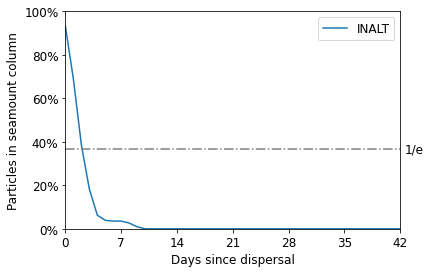

In [22]:
plt.plot(atmount_INALT1,label='INALT')
#plt.plot(atmount_ROMS1, color = 'tab:brown',label='ROMS')
#plt.plot(atmount_ROMSchild1, color = 'green',label='ROMS child')

threshold = 1/np.e

lines = plt.gca().get_lines()
x_data = lines[0].get_xdata()
y_data1 = lines[0].get_ydata()
#y_data2 = lines[1].get_ydata()
#y_data3 = lines[2].get_ydata()

intersec_INALT = None
#intersec_ROMS = None
#intersec_ROMSchild = None

for i in range(len(x_data)):
    if y_data1[i] < threshold and intersec_INALT is None:
        intersec_INALT = x_data[i]
    #if y_data2[i] < threshold and intersec_ROMS is None:
    #    intersec_ROMS = x_data[i]
    #if y_data3[i] < threshold and intersec_ROMSchild is None:
    #    intersec_ROMSchild = x_data[i]

#Intersec times
print("Level 1:")
if intersec_INALT is not None:
    print(f"INALT is below the 1/e threshold at obs = {intersec_INALT}.")
else:
    print(f"INALT does not pass the 1/e threshold.")

#if intersec_ROMS is not None:
#    print(f"ROMS (parent) is below the 1/e threshold at obs = {intersec_ROMS}.")
#else:
#    print(f"ROMS (parent) does not pass the 1/e threshold.")

#if intersec_ROMSchild is not None:
#    print(f"ROMS (child) is below the 1/e threshold at obs = {intersec_ROMSchild}.")
#else:
#    print(f"ROMS (child) does not pass the 1/e threshold.")

plt.axhline(y=threshold, color='gray', linestyle='-.')
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.xticks([0,7,14,21,28,35,42],fontsize=12)
plt.yticks([0,0.2,.4,.6,.8,1],['0%','20%','40%','60%','80%','100%'],fontsize=12)
plt.xlim([0,42])
plt.ylim([0,1])
plt.ylabel('Particles in seamount column',fontsize=12)
plt.xlabel('Days since dispersal',fontsize=12)

plt.legend(fontsize=12)
plt.show()

Level 2:
INALT is below the 1/e threshold at obs = 8.0.


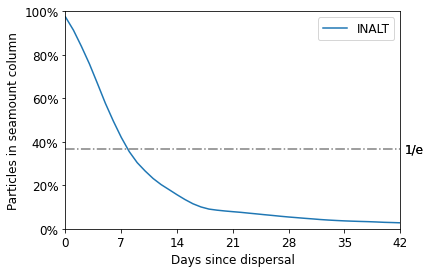

In [23]:
plt.plot(atmount_INALT2,label='INALT')
#plt.plot(atmount_ROMS2, color = 'tab:brown',label='ROMS')
#plt.plot(atmount_ROMSchild2, color = 'green',label='ROMS child')

threshold = 1/np.e

lines = plt.gca().get_lines()
x_data = lines[0].get_xdata()
y_data1 = lines[0].get_ydata()
#y_data2 = lines[1].get_ydata()
#y_data3 = lines[2].get_ydata()

intersec_INALT = None
#intersec_ROMS = None
#intersec_ROMSchild = None

for i in range(len(x_data)):
    if y_data1[i] < threshold and intersec_INALT is None:
        intersec_INALT = x_data[i]
    #if y_data2[i] < threshold and intersec_ROMS is None:
    #    intersec_ROMS = x_data[i]
    #if y_data3[i] < threshold and intersec_ROMSchild is None:
    #    intersec_ROMSchild = x_data[i]

#Intersec times
print("Level 2:")
if intersec_INALT is not None:
    print(f"INALT is below the 1/e threshold at obs = {intersec_INALT}.")
else:
    print(f"INALT does not pass the 1/e threshold.")

#if intersec_ROMS is not None:
#    print(f"ROMS (parent) is below the 1/e threshold at obs = {intersec_ROMS}.")
#else:
#    print(f"ROMS (parent) does not pass the 1/e threshold.")

#if intersec_ROMSchild is not None:
#    print(f"ROMS (child) is below the 1/e threshold at obs = {intersec_ROMSchild}.")
#else:
#    print(f"ROMS (child) does not pass the 1/e threshold.")

plt.axhline(y=threshold, color='gray', linestyle='-.')
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.xticks([0,7,14,21,28,35,42],fontsize=12)
plt.yticks([0,0.2,.4,.6,.8,1],['0%','20%','40%','60%','80%','100%'],fontsize=12)
plt.xlim([0,42])
plt.ylim([0,1])
plt.ylabel('Particles in seamount column',fontsize=12)
plt.xlabel('Days since dispersal',fontsize=12)

plt.legend(fontsize=12)
plt.show()

Level 3:
INALT is below the 1/e threshold at obs = 31.0.


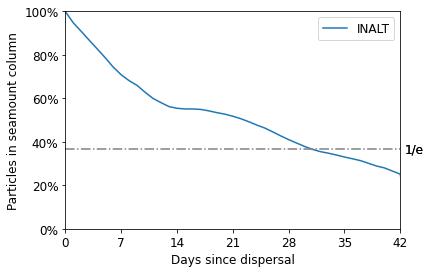

In [24]:
plt.plot(atmount_INALT3,label='INALT')
#plt.plot(atmount_ROMS3, color = 'tab:brown',label='ROMS')
#plt.plot(atmount_ROMSchild3, color = 'green',label='ROMS child')

threshold = 1/np.e

lines = plt.gca().get_lines()
x_data = lines[0].get_xdata()
y_data1 = lines[0].get_ydata()
#y_data2 = lines[1].get_ydata()
#y_data3 = lines[2].get_ydata()

intersec_INALT = None
#intersec_ROMS = None
#intersec_ROMSchild = None

for i in range(len(x_data)):
    if y_data1[i] < threshold and intersec_INALT is None:
        intersec_INALT = x_data[i]
    #if y_data2[i] < threshold and intersec_ROMS is None:
    #    intersec_ROMS = x_data[i]
    #if y_data3[i] < threshold and intersec_ROMSchild is None:
    #    intersec_ROMSchild = x_data[i]

#Intersec times
print("Level 3:")
if intersec_INALT is not None:
    print(f"INALT is below the 1/e threshold at obs = {intersec_INALT}.")
else:
    print(f"INALT does not pass the 1/e threshold.")

#if intersec_ROMS is not None:
#    print(f"ROMS (parent) is below the 1/e threshold at obs = {intersec_ROMS}.")
#else:
#    print(f"ROMS (parent) does not pass the 1/e threshold.")

#if intersec_ROMSchild is not None:
#    print(f"ROMS (child) is below the 1/e threshold at obs = {intersec_ROMSchild}.")
#else:
#    print(f"ROMS (child) does not pass the 1/e threshold.")

plt.axhline(y=threshold, color='gray', linestyle='-.')
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.text(42.5,0.35,'1/e',fontsize=12)
plt.xticks([0,7,14,21,28,35,42],fontsize=12)
plt.yticks([0,0.2,.4,.6,.8,1],['0%','20%','40%','60%','80%','100%'],fontsize=12)
plt.xlim([0,42])
plt.ylim([0,1])
plt.ylabel('Particles in seamount column',fontsize=12)
plt.xlabel('Days since dispersal',fontsize=12)

plt.legend(fontsize=12)
plt.show()